The analysis module uses **exploratory modeling and analysis workbench** along with widely used data processing libraries **pandas** and **numpy**. The **seaborn** library is used to generate heatmap visualizations of the results of the analysis. 

In [13]:
from __future__ import (absolute_import, print_function, division,
                        unicode_literals)


from ema_workbench import (Model, RealParameter, MultiprocessingEvaluator, CategoricalParameter,
                           IntegerParameter, ScalarOutcome, ArrayOutcome, Constant, ema_logging,
                           perform_experiments)
from ema_workbench.em_framework.evaluators import (MC,LHS,SOBOL)

from ema_workbench.analysis import feature_scoring

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Data-Driven Exploratory Analysis

Exploratory modeling and simulation is an effective strategy when there is contextual uncertainty in problem formulation. However, two significant challenges impede the use of an ensemble of models in exploratory simulation. The first challenge involves streamlining the maintenance and synthesis of multiple models from plausible features that are identified from and subject to the constraints of the research hypothesis. Section 3 highlighted this challenge and provided a solution strategy to address the identified technical requirements.  The second challenge is making sense of the data generated by multi-simulation over a model ensemble.

An analytical tool built for generalization and explanation yields a proper interpretation of large ensembles.  It can provide insight into areas of the ensemble not otherwise explicitly evaluated and give decision-makers a better understanding of how systemic policies and strategies generally behave with results transposed into sensible chunks. An explainable analysis of a model can accelerate the exploratory modeling process by supplying intuitive interpretations of experiments.

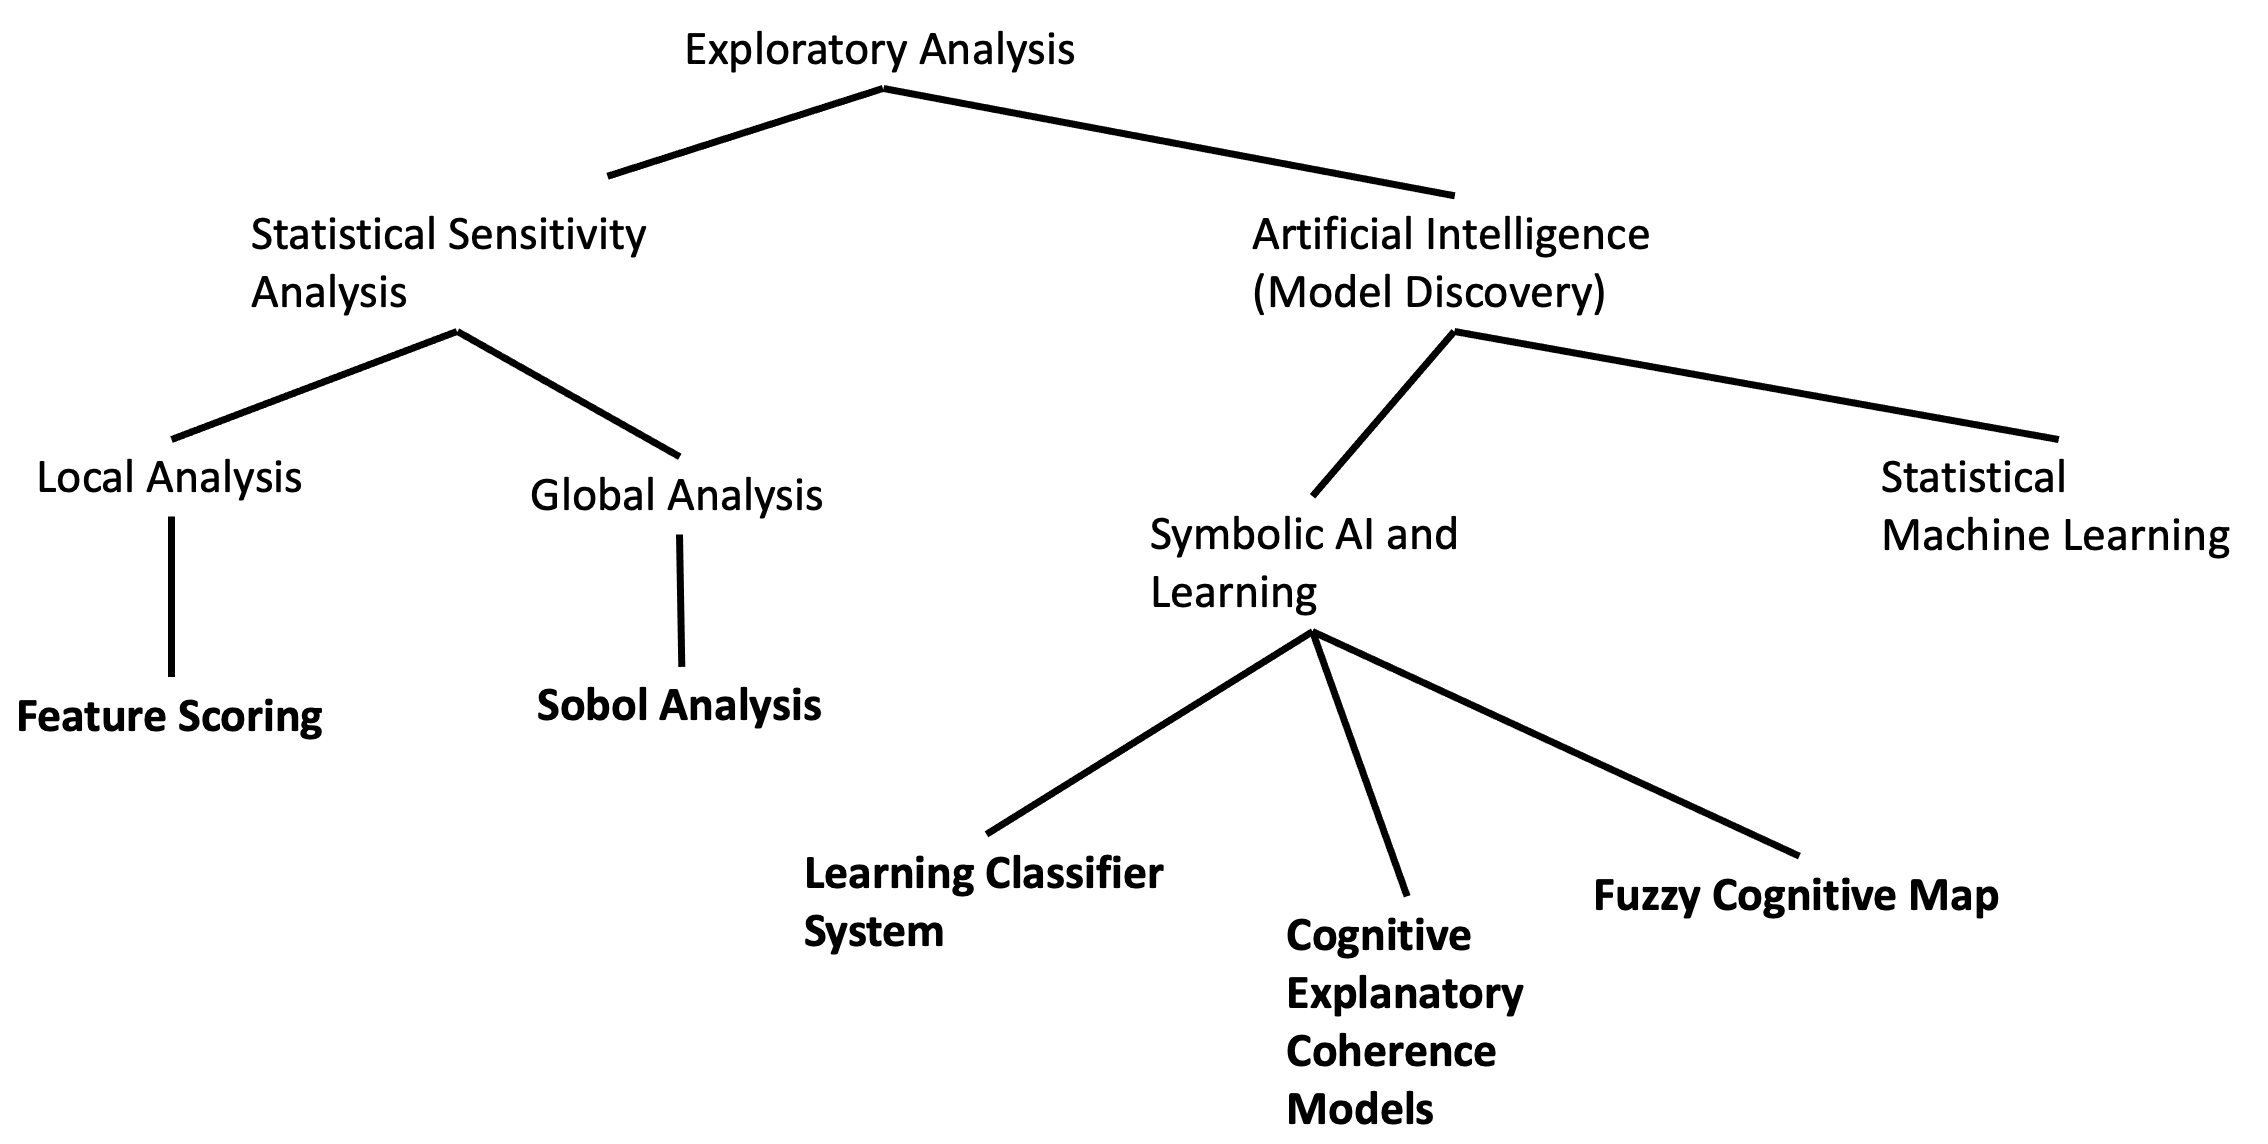

## Feature Scoring

Feature scoring and ranking can help understanding the data in supervised settings. It is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature scoring is used for several reasons:

* abstraction of models by simplifying the state space to make them easier to communicate to researchers and users,
* reducing the training time needed by enabling the projection of the raw data onto selected relevant features,
* item to help avoid the curse of dimensionality (e.g., the amount of data needed to support the result often grows exponentially with the dimensionality) by organizing and analyze data in high-dimensional spaces,
* improve generalization by reducing overfitting

The central tenet of using a feature scoring/selection technique is based on the observation that the data contains features that are either redundant or irrelevant, and can thus be removed without incurring much loss of information. There are various methods, including information-theoretic and statistical techniques, used in feature scoring. A common strategy is to apply linear regression tests for evaluating the individual effect of each of many regressors. This is a scoring function to be used in a feature selection procedure, not a free standing feature selection procedure. This is done in 2 steps: Given as input $X$ ({array-like, sparse matrix} representing the experiment design space with a shape = ($n\_samples$, $n\_features$)), the set of regressors that will be tested sequentially, and  $y$ (array of shape($n\_samples$)), the outcome matrix, the correlation between each regressor and the target is computed using the Python language notation as follows:

$((X[:, i] - mean(X[:, i])) * (y - mean\_y)) / (std(X[:, i]) * std(y))$.

The result is converted to an \textit{F score} then to a \textit{p-value}. The lower the p-value, the higher the impact of a feature on the performance measure specified by $y$. The following script demonstrates how the experiment design and outcomes data frames produced by *PyOmega* via the *EMA-OMEGA* connector software are utilized to determine the impact of features (dependent variables) on performance measures. 

In [15]:
from ema_workbench.analysis import feature_scoring
import pandas as pd

data = pd.read_csv('omegaExperiment.csv')
outcomes = pd.read_csv('omegaResults.csv')

data = data[['SCUDB.targetRange', 'SCUDB.targetAltitude', 'SCUDB.MassProperties.initialMass']]
outcomes = outcomes[['burnout', 'impact', 'apogeeAlt', 'apogeeTime']]

The feature scoring analysis starts with the experiment design data frame and the outcomes frame, which are projected onto selected features and performance measures of interest that are consistent with the objectives of the simulation study. 

Following the projection of experiment design and outcome data frames onto independent experiment design variables (i.e., *targetRange*, *targetAltitude*, *initialMass*) and performance measures of interest (i.e., *impact*, *burnout*, *apogeeAlt*, *apogeeTime*), feature scoring is performed based on the  $F\_REGRESSSION$ method. The **F-value** and **p-value** vectors for the four outcome metrics are calculated and reported as follows:

In [16]:
z1 = feature_scoring.F_REGRESSION(X=data, y=outcomes['apogeeAlt'])

In [17]:
z1

(array([1809.9751893 ,   16.16937605,    5.04024853]),
 array([5.47581348e-65, 1.13908724e-04, 2.70125584e-02]))

Clearly, the p-values listed in the second vector above suggest that the first parameter, *targetRange* is the most significant variable that explains the variation in the output variable *ApogeAlt*.

In [18]:
z2 = feature_scoring.F_REGRESSION(X=data, y=outcomes['burnout'])

In [19]:
z2

(array([ 69.99279162,   7.12105111, 135.28916363]),
 array([4.17146228e-13, 8.91668003e-03, 3.66173399e-20]))

The p-values for the independent variables with respect to the dependent (output) variable *burnout* suggest that the *initialMass* is the most significant predictor of the variation in burnout time.

The calculation of F and p-values for each dependent variable is tractable when the number of performance metrics is relatively small. However, when the number of dependent variables is large, it is useful to have a utility that can calculate all the scores and to make it availabke in a form that is easier to communicate. The following illustration shows how  regression analysis can be obtained and transformed into scores for each dependent variable across all performance metrics.

In [20]:
z = feature_scoring.get_feature_scores_all(x=data, y=outcomes)

In [21]:
z

,burnout,impact,apogeeAlt,apogeeTime
SCUDB.MassProperties.initialMass,0.571782,0.034776,0.078503,0.028920
SCUDB.targetAltitude,0.129950,0.254360,0.228897,0.254185
SCUDB.targetRange,0.298267,0.710864,0.692600,0.716895


The resultant table above shows the feature scores for each independent variable across performance metrics. Each row is associated with a single independent variable, either a design or context parameter. The columns represent the performance metrics. The results suggest that *initialMass* is the most significant predictor of *burnout*, and *targetRange* is the most significant fcator explaining the variation in the dependent variables *impact time*, *apogee altitude*, and *apogee time*

The following heatmap communicates the results in a visually appealing manner.

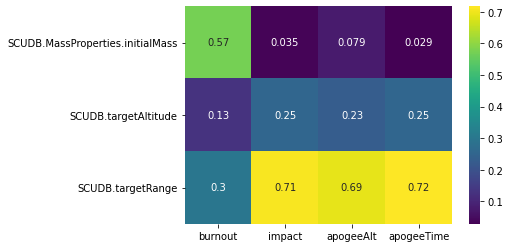

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(z, cmap='viridis', annot=True)
plt.show()

## Variance-Based Sensitivity Analysis

Variance-based sensitivity analysis (often referred to as the Sobol method or Sobol indices, after Ilya M. Sobol) is a form of global sensitivity analysis Working within a probabilistic framework, it decomposes the variance of the output of the model or system into fractions which can be attributed to inputs or sets of inputs. For example, given a model with two inputs and one output, one might find that 70% of the output variance is caused by the variance in the first input, 20% by the variance in the second, and 10% due to interactions between the two. These percentages are directly interpreted as measures of sensitivity. Variance-based measures of sensitivity are attractive because they measure sensitivity across the whole input space (i.e. it is a global method), they can deal with nonlinear responses, and they can measure the effect of interactions in non-additive systems

In [ ]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

    res = perform_experiments(model, scenarios = 10, uncertainty_sampling = 'sobol')
    experiments, outcomes = res
    problem = get_SALib_problem(model.uncertainties)
    Si = sobol.analyze(problem, outcomes['apogeeAlt'],
                       calc_second_order=True, print_to_console=False)

    print(Si['S1'])
    print('interactions')
    print(Si['S2'])

    scores_filtered = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1', 'ST']]
    err = Si_df[['S1_conf', 'ST_conf']]

    indices.plot.bar(yerr=err.values.T, ax=ax)
    fig.set_size_inches(8, 6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()

## Interactive Exploratory Analysis

Traditional approaches to sensitivity analysis use the computer as an elaborate calculator.  Analysts initially carry out detailed exercises in reasoning  to  draft  the  best  model  and  examine  all  the  assumptions relevant  to  a  particular  decision  before feeding  the  results  into  the computer. The computer produces a ranking of alternative strategies contingent  on  these  assumptions  and,  in  particular,  identifies  the optimum. More-sophisticated  efforts  may  also  include  analysis  of how  sensitive  the  optimal  strategy  is  to  the  various  assumptions made  at  the  start  of  the  analysis. Then, leaving the computer aside, analysts provide a synopsis of the results to decision makers who engage in a subsequent and separate process to integrate the results—along with a great deal of information  not  included  in  the  computer’s  calculations—into the fabric of decision making. 

Modern  information  technology  makes possible  a  new  and  more powerful form of human-machine collaboration, one better suited to finding  adaptive  strategies  that  are  robust  over  time.    Rather  than restrict the computer's province to serving as a calculator, its capabilities may be used to handle, display, and summarize vast quantities of information.  The computer thus becomes a device that, from the  outset  of  the  analytical  process,  helps  humans  shape  and  test hypotheses  about  the  most  robust  designs  to  take  in  the face  of  multiple  scenarios. Such  information  is  often  most usefully  presented  in  the  form  of  interactive  computer-generated visualizations  that  can  be  regarded  metaphorically  as  maps  of  the many potential paths contingent on scenarios.  

The computer helps humans identify, create, and explore the maps most useful to chart the  next  steps  of  the  journey. These  artifacts  can  become  a  crucial structure for a conversation among the parties to a decision.  Human debates  that  remain  unaided  by  data  and  the  causal  information contained in computer simulations often degenerate into contests of convincing  narrative.    The  best-told  story  becomes  the  most  compelling argument, whether or not it reflects available information. In contrast, a robust exploratory analysis approach can free humans to pursue the full  range  of  their  imaginations,  tethered  only  by  the  constraints  of what is known.

**Forming Hypotheses about Robust Strategies**: Having gathered the initial information, users next employ the computer  and  its  scenario  generator  to  create  an  ensemble  of  plausible scenarios. Each  scenario  consists  of  one  particular choice  of  strategy, often adaptive, and one particular manifestation of a design. At this point, users can explore these scenarios by creating interactive computer visualizations referred to as landscapes of  plausible  futures.    These  two-  or  three-dimensional  graphics apply one or more values to compare the performance of alternative strategies across a range of contextual conditions. By  considering  these  ensembles  of  scenarios,  the human-computer team then identifies strategies that are potentially robust over the range of contexts (path "a" in the following Figure).

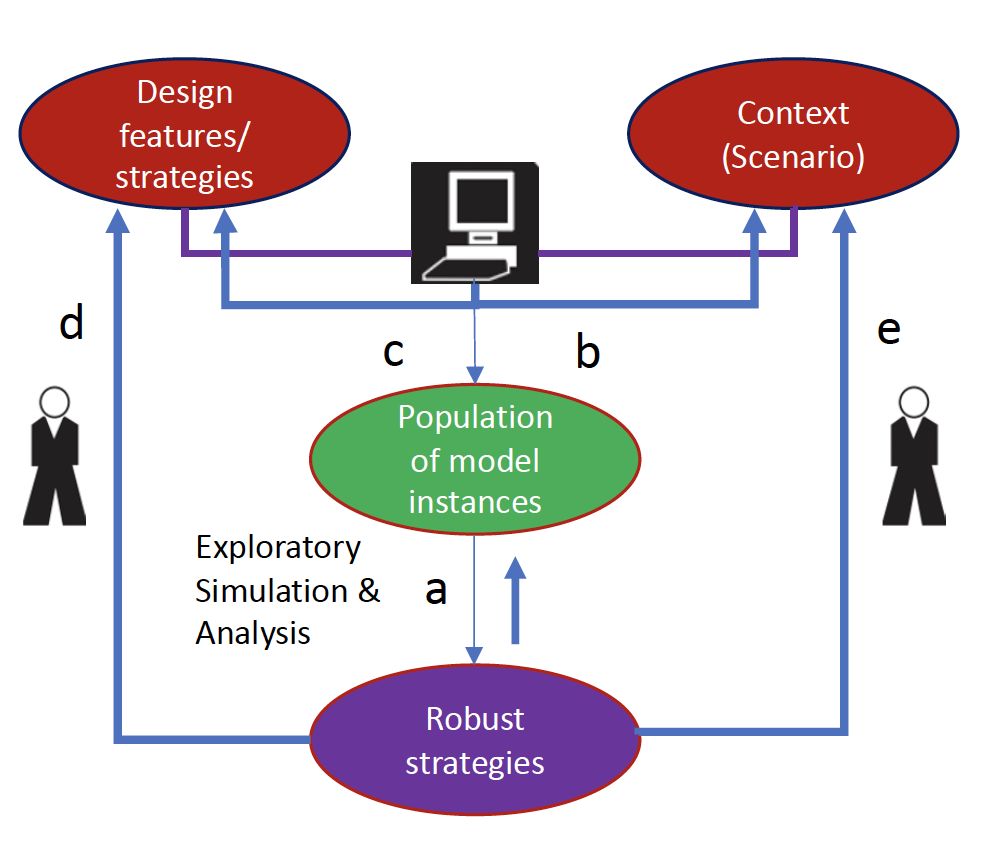

**Testing Hypotheses**: Once they  have  formed  initial  claims  about  robust  strategies,  users can  test  and  revise  these  hypotheses  through  computer  search  for other  contexts  that  would  invalidate  that  claim  (path  "b"),  and  then help  identify  additional  promising  alternative  strategies  (path  "c"). Computer-search  algorithms  can  suggest  contexts  that  could  cause candidate  robust  strategies  to  fail  and  find  alternatives  that  might perform  well  under  the  newly  specified  conditions.    Again,  interactive  visualization  is  a  powerful  means  to  help  people  judge whether  these  conditions  pose  sufficient  risks  to  warrant  revising  the design/strategy.    The  particular  landscapes  that  display  such  comparisons are  termed  "robust  regions". These searches for "breaking" scenarios may occur entirely within the  space  of  futures  and  strategies  contained  in  the  initial  ensemble  -- that  is,  within  the  capabilities  of  the  current  scenario  generators.  

As the analysis proceeds, human participants in the analysis are encouraged to hypothesize about strategic options that might prove more  robust  than  the  current  alternatives  (path  "d")  or  to  suggest “surprises”  that  might  occur  in  the  future  to  cause  an  apparently robust strategy to fail (path "e").  These new candidates can be added to  the  scenario  generator  and  their  implications  dispassionately explored by the computer.Information  gathering  occurs  throughout  the  analysis. Given  the unpredictability of the plausibility of contextual conditions, no one can determine a priori all the factors  that  may  ultimately  prove  relevant  to  the  decision.    Thus, users  will  frequently  gather  new  information  that  helps  define  new conditions  relevant  to  the  choice  among  strategies,  that  proves  some conditions  implausible  and  thus  removes  them  from  the  ensemble,  or that represents new, potentially promising strategies.

The overall strategy can be summarized as follows:  
* Each experiment consists of one particular choice of strategy/design, often adaptive, and one particular manifestation of a context
* Form initial claims about robust strategies via exploratory analysis
* Use scenario discovery algorithms to cause candidate robust strategies to fail and find alternatives that might perform well under the newly specified conditions.
    * test and revise these hypotheses through computer search for other scenarios that would invalidate that claim (path "b"), and then
    * help identify additional promising alternative designs (path "c”).

### Using the Regret Metric for Robustness and Value of Information Analysis

The **relativeRegret** function calculates the regret values associated with each pair of **(design, context)** configuration.  That is, the performance of a specific design, *X* is compared to the alternative designs under a given scenario (context), and the difference between the best design solution and *X* is defined as the regret value for *X*. The regret values for each design under each scenario are calculated to provide a basis for **robustness analysis**.

The function takse as input the experiment design matrix (data), the outcomes data frame, design parameters (designParams), contextual parameters that define the scenario space,and the performance measure for which the regret measures are collected. The output of the **relativeRegret** is a triplet: the regret matrix, the distinct design data points in the experiment design frame (data), and the distinct context data points in the same experiment design frame. The regret matrix is defined as a dictionary,  *{(d,s): r}*, where *d* and *r* represent the design and context data points, respectively.


In [23]:
def relativeRegret(data,outcomes,designParams,contextParams,outcomeParams):
    myres = {}
    design = []
    scenario = []
    designSet = set()
    contextSet = set()

    for ind in data.index:
        for i in designParams:
            design.append(data[i][ind])
        for j in contextParams:
            scenario.append(data[j][ind])
        elm = {(tuple(design), tuple(scenario)): outcomes[outcomeParams[0]][ind]}
        myres.update(elm)
        designSet.add(tuple(design))
        contextSet.add(tuple(scenario))
        design = []
        scenario = []

    measures = {}
    for sc in contextSet:
        m = []
        for d in designSet:
            o = myres[(d, sc)]
            m.append(o)
            measures[sc] = m

    maxs = {}
    for sc in contextSet:
        maxs[sc] = max(measures[sc])

    regret = {}
    for sc in contextSet:
        for d in designSet:
            rm = {(d, sc): (maxs[sc] - myres[(d, sc)]) / maxs[sc]}
            regret.update(rm)

    return (regret,contextSet,designSet)

The **minmax** function uses the output of the relativeRegret function anc calculates the design solution that has the minimum worst regret across all designs. The function returns the design information (a tuple of values of design parameters) and the associated regret value that is minimum of worst-case regrets of designs.

In [24]:
def minmax(r,dsg,ctx):
    worstRegret = {}
    for d in dsg:
        rdata = []
        for sc in ctx:
            rdata.append(r[d, sc])
        elm = {d: rdata}
        worstRegret.update(elm)

    maxs = []
    maxvs = []
    for d, l in worstRegret.items():
        maxs.append(max(l))
        maxvs.append((d, max(l)))

    minmax = min(maxs)
    minmaxKey=0
    for x in maxvs:
        if (x[1] == minmax):
            minmaxKey = x[0]

    return minmaxKey,minmax

The experiment design matrix and the results of exploratory simulation with the Omega model are retrieved from data fles and stored in two data frames: **data** and **outcomes**.

In [22]:
data = pd.read_csv('omegaExperiment.csv')
outcomes = pd.read_csv('omegaResults.csv')


The analysis can select spefific features (design and scenario factors) and performance measures. The following script projects the experiment frame (data) onto **SCUDB.targetRange**, **SCUDB.targetAltitude**, and **SCUDB.MassProperties.initialMass**.  In this illustrative example, the *initialMass* variable is a design parameter while *targetAltitude* and *targetRange* are context parameters.

In [23]:
data = data[['SCUDB.targetRange', 'SCUDB.targetAltitude', 'SCUDB.MassProperties.initialMass']]
outcomes = outcomes[['burnout', 'impact', 'apogeeAlt', 'apogeeTime']]

The following table shows the experiment design data frame. Lating Hypercube Sampling strategy is used to generate 10 data points from the design parameter space and 10 points from the context (scenario) space. Then full factorial design is used to generate cross-product of the data points. Each design space data point is paired with 10 scenario data points, resulting in 10 x 10 = 100 experiment configurations as shown below.

In [24]:
data

,SCUDB.targetRange,SCUDB.targetAltitude,SCUDB.MassProperties.initialMass
0,194309.994762,17899.496516,5934.265685
1,101654.444957,19863.285663,5934.265685
2,177970.762969,17139.581542,5934.265685
3,139675.343339,16989.007168,5934.265685
4,154970.990475,19331.595554,5934.265685
...,...,...,...
95,188804.475102,15168.837085,5475.705879
96,123257.336063,16463.010894,5475.705879
97,163408.151044,18282.136538,5475.705879
98,117220.924396,18513.405635,5475.705879


The outcomes data table stores the results of the experiments. Each row of the table shows the result of the experiment defined by the respective row in the experiment frame shown above. Each column represents a specific performance metric (e.g., burnout time, impacttime) and its observed values across the experiments conducted during exploratory simulation.

In [9]:
outcomes

,burnout,impact,apogeeAlt,apogeeTime
0,59.455,253.126052,64091.619486,153.485
1,51.925,189.092099,40701.534735,122.590
2,58.285,243.733718,59677.919089,148.220
3,55.290,219.136536,49752.052975,135.510
4,56.735,227.932595,54303.500372,141.500
...,...,...,...,...
95,54.435,252.246883,64136.339283,149.645
96,49.720,210.311915,47560.836808,128.905
97,52.955,235.312020,58328.474062,142.755
98,49.360,204.666454,46526.667478,127.485


Next, we select a subset (or all) of the features of the experiment to focus on a specific research question. 
For illustraton purposes, in this example, we focus on the design and context parameters defined earlier while
narrowing our focus only to the *burnout time*, which is one of the four performance metrics measured in this 
hypothetical simulation study.

In [10]:
designParams = ['SCUDB.MassProperties.initialMass']
contextParams = ['SCUDB.targetRange', 'SCUDB.targetAltitude']
outcomeParams = ['burnout']

Given the design, context (scenario), and outcome parameters of interest, the **relativeRegret** function is applied to calculate 
the regret values associated with (design,scenario) pairs. The result (r,ctx,dsg) includes the regret matrix, as well as the
context and design data points used in the calculation of regret vvalues.

In [11]:
r,ctx,dsg = relativeRegret(data,outcomes,designParams,contextParams,outcomeParams)

In [13]:
ctx

{(101654.44495714606, 19863.2856633292),
 (117220.92439644404, 18513.40563481938),
 (123257.33606324367, 16463.010893961884),
 (139675.3433389943, 16989.007167849442),
 (148417.11782261735, 15978.20539939137),
 (154970.9904749166, 19331.59555397015),
 (163408.15104448446, 18282.13653790799),
 (177970.76296935216, 17139.581542399686),
 (188804.47510191367, 15168.837085361632),
 (194309.99476155106, 17899.49651565495)}

In [14]:
dsg

{(5046.555985630564,),
 (5112.418074245511,),
 (5213.449448020529,),
 (5393.467446169235,),
 (5475.705879031485,),
 (5542.0918727504795,),
 (5615.723213974947,),
 (5725.084392914211,),
 (5816.6294417382705,),
 (5934.265685006311,)}

For instance, the following is the relative regret (commpared to maximum regret) of the design parameter value
5046.555985630564 under the scenario (101654.44495714606, 19863.2856633292) that represents a specific target altitude 
and target range. 

In [29]:
r[((5046.555985630564,),(101654.44495714606, 19863.2856633292))]

0.14299470389985552

The **minmax** function determines which specific design/strategy minimizes the worst regret. 
The function considers the worst regret value for each design alternative across all scenarios and 
chooses the one that the lowest worst regret.

In [25]:
a,b = minmax(r,dsg,ctx)

In this illustrative example, the design (i.e., *initialMass* value of 5934.265685006311) has the minimum worst regret.
The value of the minimum worst case regret is 0.0. Coincidentally, this indicates that the specific *initialMass* value associated with 
the design is optimal across all scenarios, and the outcome for this design configuration is not sensitive to contextual 
conditions with respect to the perfoemance metric of interest (i.e., *burnout time*).

In [20]:
(a,b)

((5934.265685006311,), 0.0)

The following script illustrates how the distribution of regret values across (design,context) pairs can be visualized using a **heatmap**. A two-dimensional regret matrix, *mat*, is initialized with data using the regret dictionary generated by the relativeRegret function. The *heatmap* utitity of the *seaborn* package is used to visualize the regret values. In this illustrative example, with respect to the *burnout* metric, none of the design configurations is sensitive to variation in the scenario space, and one of the design alternatives (row 5) representing the *initialMass* value of 5934.265685006311 has the lowest worst regret.

The rows of the heatmap matrix refer to alternative designs while columns represent the scenarios. The color coding used in the visualization depict the relative regret values associated with design scenario pairs. The heatmap reveals that the impact of alternative design configurations (i.e., initialMass values) on the performance metric (i.e., burnout time) is not sensitive to variation in the target altitude and target range values in the scenario space. Each design maintains a stable level of regret across scenarios. To characterize the robust design configuration with respect to the selected performance metric, we use the *minmax regret* metric that selects the minimum regret value from among the max regret values of designs. The design that minimizes the worst regret is selected as the most robust solution strategy. The following script iterates over the design, scenario pairs and determines the maximum (worst) regret for each design point over the scenario space. Once the worst regret levels of each design point is identified, the minimum regret value out of maximum regrets is selected along with the corresponding design configuration.

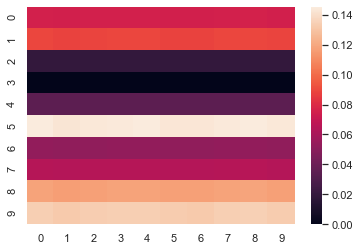

In [30]:
regretData = []
sns.set()
mat = np.random.rand(len(dsg),len(ctx))

i = 0
j = 0
for d in dsg:
    j=0
    for sc in ctx:
        mat[i,j]= r[d,sc]
        regretData.append(mat[i,j])
        j=j+1
    i=i+1

sns.set()
vM = max(regretData)
vm = min(regretData)
ax = sns.heatmap(mat, vmin=vm, vmax=vM)
plt.show()

The regret metric can be used to discern the *value of information* by attributing to scenarios regret-based risk values. Those scenarios that consistently result in high regret values across design alternatives inform decision-makers about what information to seek prior to making a decision. Scenarios that exhibit high regret values have high value of information, for the cost of not knowing a specific situation in the scenario space with a high regret value is relatively more than the cost that incurs in other plausible situations. Conversely, knowing or anticipating the contextual situation can facilitate choosing a solution that outperforms alternatives across a broad range of scenarios but results in high-levels of regret for only a narrow range of scenarios. In the absence of information, relying on robust designs that minimize worst regret is a prudent choice. 

As observed in this illustrative example, if design alternatives are not sensitive to scenarios, for their worst case regret values are constant across all scenarios, the parameters in the scenario space are irrelevant and do not add value to the confidence of the results with repect to the selected performance metric, which in this case is the burnout time

# Discovering Feature Interaction Patterns using Learning Classifier Systems 